####
We should put some if clauses such that if contract expires or there is a release clause our prediction is not made by the model, but we already know the transfer value
###

In [80]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble  import RandomForestRegressor
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from xgboost import XGBRegressor

In [103]:
# read files
from pathlib import Path
path = str(Path("andrea_models.ipynb").parent.absolute().parent.absolute()) + "/data/Final/"
csv_files = glob.glob(os.path.join(path, "*.csv"))

# create unique dataframe with all the players
players = []

# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)

    # append the dataframe to the list
    players.append(df)

data = pd.concat(players).reset_index(drop = True)

# save player_name in a variable
player_name = data["player_name"]

# drop the columns that are not needed
data.drop(["player_name", "short_name", "previous_short_name", "name_similarity", "club_similarity", "new_club", "old_club", "club_name"], axis = 1, inplace = True)

data.head()

,transfer_period,fee,year,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,...,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_D,position_G,position_M,attack_work_rate,defense_work_rate
0,0,9.0,2020,63.0,77.0,750000.0,2000.0,18.0,186.0,74.0,...,10.0,11.0,9.0,10.0,0.0,0.0,0.0,1.0,3.0,2.0
1,1,0.0,2020,72.0,75.0,4000000.0,12000.0,25.0,181.0,69.0,...,14.0,6.0,14.0,10.0,1.0,0.0,0.0,0.0,2.0,2.0
2,1,0.0,2020,72.0,72.0,2700000.0,30000.0,31.0,182.0,74.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0
3,1,0.0,2020,60.0,76.0,425000.0,2000.0,18.0,183.0,78.0,...,13.0,13.0,12.0,8.0,1.0,0.0,0.0,0.0,2.0,2.0
4,1,4.0,2020,73.0,81.0,6000000.0,21000.0,22.0,178.0,76.0,...,14.0,12.0,15.0,11.0,1.0,0.0,0.0,0.0,3.0,1.0


In [106]:
# print player_name where release_clause_eur is lower than fee
player_name[data["release_clause_eur"] / 1000000 < data["fee"]]

0         Kouadio Koné
8           Nathan Aké
20      Frederik Alves
21      Mohammed Kudus
26      Jonathan Panzo
             ...      
1315            Bremer
1317            Antony
1324       Min-jae Kim
1327           Vitinha
1331       Samuel Lino
Name: player_name, Length: 262, dtype: object

In [82]:
# train-test split, use random_state = 0
train_valid, test = train_test_split(data, test_size = 0.2, random_state = 0)

# remove zero fees
train_valid_no_zero = train_valid[train_valid["fee"] != 0]
test_no_zero = test[test["fee"] != 0]

In [42]:
# print them in new csv so we can use them in the other notebook
train_valid.to_csv("train_valid.csv", index = False)
test.to_csv("test.csv", index = False)

In [83]:
# define target and features
target = "fee"

In [84]:
# distribution
train_valid.shape
test.shape

(269, 64)

## Data pre-processing: fees and release clauses

In [85]:
train_valid_no_zero["release_clause_eur"] = train_valid_no_zero["release_clause_eur"] / 1000000

/var/folders/lf/rts57f595bn_1gbpcfsjp4br0000gn/T/ipykernel_64248/3251400013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_valid_no_zero["release_clause_eur"] = train_valid_no_zero["release_clause_eur"] / 1000000


In [86]:
# compare train_valid_no_zero.fee and train_valid_no_zero.release_clause_eur
train_valid_no_zero["fee"].describe()

count    647.000000
mean      10.590943
std       15.341428
min        0.100000
25%        2.000000
50%        4.500000
75%       13.000000
max      117.500000
Name: fee, dtype: float64

In [87]:
train_valid_no_zero["release_clause_eur"].describe()

count    647.000000
mean      16.995799
std       24.763057
min        0.150000
25%        2.800000
50%        8.400000
75%       20.350000
max      206.900000
Name: release_clause_eur, dtype: float64

In [88]:
# only consider players with a release clause > 0
positive_release_clause = train_valid_no_zero[train_valid_no_zero["release_clause_eur"] > 0]

# compare fees and release clause columns
difference = positive_release_clause["release_clause_eur"] - positive_release_clause["fee"]
difference.describe()

count    647.000000
mean       6.404856
std       19.109330
min      -80.000000
25%       -1.050000
50%        2.200000
75%       10.950000
max      154.900000
dtype: float64

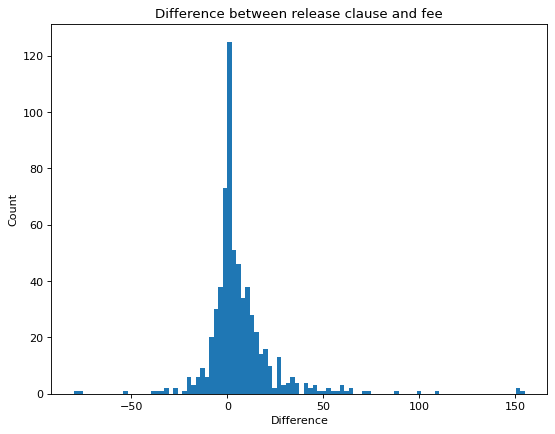

Proportion of negative values in difference:  31.993817619783616


In [89]:
# plot the difference
figure(figsize=(8, 6), dpi=80)
plt.hist(difference, bins = 100)
plt.title("Difference between release clause and fee")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()

# print proportion of negative values in difference
print("Proportion of negative values in difference: ", len(difference[difference < 0]) / len(difference) * 100)

## Define functions that will be used across models

In [45]:
def get_features(df):
    return df.drop(target, axis = 1)

In [46]:
def get_target(df):
    
    # apply log transformation to the target
    y = [np.log(element + 1) for element in df[target] ]
    return y

In [47]:
def compute_results(pred, test):
    # compute the mean absolute error
    mae = np.mean(np.abs(pred - test))
    # compute the mean squared error
    mse = np.mean((pred - test)**2)
    # compute the root mean squared error
    rmse = np.sqrt(mse)
    # compute the r2
    osr2 = np.mean((pred - test)**2) / np.var(test)

    # turn into dataframe
    results = pd.DataFrame({"mae": mae, "mse": mse, "rmse": rmse, "osr2": osr2}, index = [0])

    # print the results
    print(results)

In [48]:
def check_prediction_value(pred, test):

    # set dimensions
    figure(figsize=(10, 4), dpi=80)
    
    xaxes = np.arange(0, len(pred))
    plt.hist(pred, xaxes, alpha = 0.5, label = "pred", color = "red")
    plt.hist(test, xaxes, alpha = 0.5, label = "test", color = "blue")
    plt.legend(loc = "upper right")


## Linear Regression

In [29]:
def LinearRegression_model(train_valid, test):

    # define model
    model = LinearRegression()

    # fit the model
    model.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = model.predict(get_features(test))

    # transform back to original scale
    pred_scaled = [np.exp(element) - 1 for element in pred]

    # compute results
    compute_results(pred_scaled, test[target])

    check_prediction_value(pred_scaled, test[target])

    return model

        mae          mse       rmse       osr2
0  6.726943  1858.897493  43.114934  15.097701


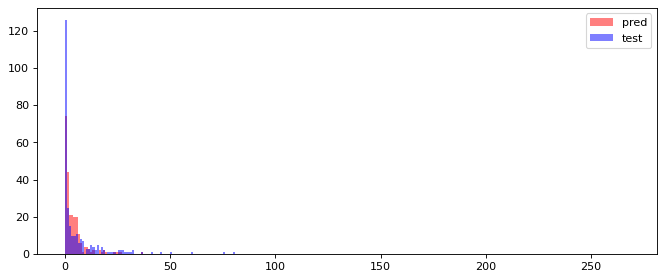

In [30]:
LinReg = LinearRegression_model(train_valid, test)

        mae        mse      rmse      osr2
0  5.786416  84.640889  9.200048  0.687441
MAE:  5.786416331990907


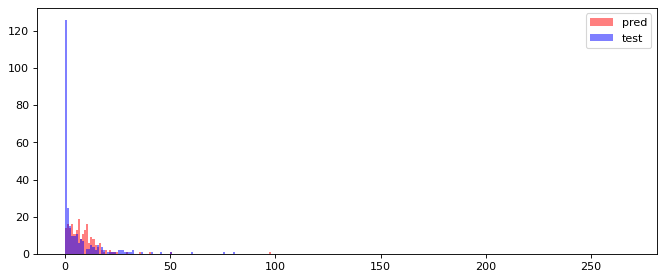

In [37]:
model = LinearRegression()

# fit the model
model.fit(get_features(train_valid), train_valid[target])

# predict
pred = model.predict(get_features(test))

# print the results
compute_results(pred, test[target])

check_prediction_value(pred, test[target])

# print MAE
print("MAE: ", np.mean(np.abs(pred - test[target])))


        mae         mse       rmse      osr2
0  6.733397  108.037144  10.394092  0.645302
MAE:  6.733396837273283


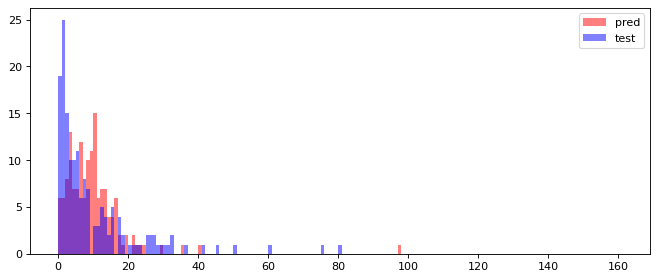

In [49]:
model_no_zero = LinearRegression()

# fit the model
model_no_zero.fit(get_features(train_valid_no_zero), train_valid_no_zero[target])

# predict
pred = model.predict(get_features(test_no_zero))

# print the results
compute_results(pred, test_no_zero[target])

check_prediction_value(pred, test_no_zero[target])

# print MAE
print("MAE: ", np.mean(np.abs(pred - test_no_zero[target])))

10.510046367851624

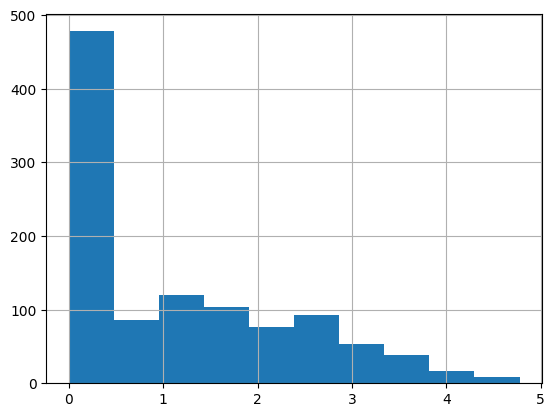

In [55]:
# distribution of target in train_valid
#train_valid[target].hist()
#train_valid[target].mean()

# distribution of target in train_valid_no_zero
#train_valid_no_zero[target].hist()
#train_valid_no_zero[target].mean()

np.log(train_valid_no_zero[target] + 1).describe()
np.log(train_valid[target] + 1).hist()

# how many values are under 1
len(train_valid_no_zero[train_valid_no_zero[target] < 1]) / len(train_valid_no_zero) * 100

## Lasso Regression

In [13]:
def Lasso_model(train_valid, test):

    # define model
    model = LassoCV(cv=5, random_state=0) # 5-fold cross validation to select the best alpha

    # fit the model
    model.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = model.predict(get_features(test))

    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    check_prediction_value(pred, get_target(test))

    return model

        mae         mse       rmse      osr2
0  6.822481  586.434623  24.216412  4.762939


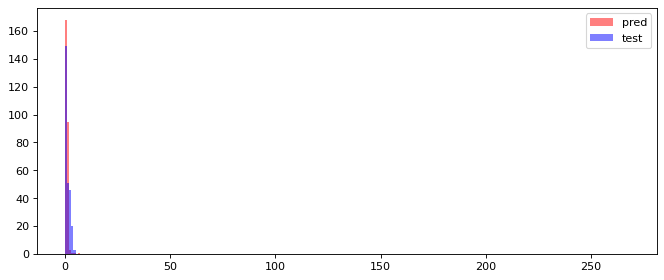

In [14]:
LassoReg = Lasso_model(train_valid, test)

## Random Forest

In [15]:
def RandomForest_model(train_valid, test):

    # define model
    model = RandomForestRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [10, 15, 20],
                  "min_samples_split": [2, 5, 10],
                  "max_features": [10, 15, 20],
                  }

    # define grid search
    grid = GridSearchCV(model, parameters, verbose = 3)

    # fit the model
    grid.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = grid.predict(get_features(test))

    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    check_prediction_value(pred, get_target(test))

    print(grid.best_params_)

    return grid.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END max_depth=10, max_features=10, min_samples_split=2;, score=0.393 total time=   0.4s
[CV 2/5] END max_depth=10, max_features=10, min_samples_split=2;, score=0.546 total time=   0.3s
[CV 3/5] END max_depth=10, max_features=10, min_samples_split=2;, score=0.419 total time=   0.3s
[CV 4/5] END max_depth=10, max_features=10, min_samples_split=2;, score=0.549 total time=   0.3s
[CV 5/5] END max_depth=10, max_features=10, min_samples_split=2;, score=0.477 total time=   0.3s
[CV 1/5] END max_depth=10, max_features=10, min_samples_split=5;, score=0.401 total time=   0.3s
[CV 2/5] END max_depth=10, max_features=10, min_samples_split=5;, score=0.544 total time=   0.4s
[CV 3/5] END max_depth=10, max_features=10, min_samples_split=5;, score=0.428 total time=   0.4s
[CV 4/5] END max_depth=10, max_features=10, min_samples_split=5;, score=0.562 total time=   0.3s
[CV 5/5] END max_depth=10, max_features=10, min_samples_split=5;,

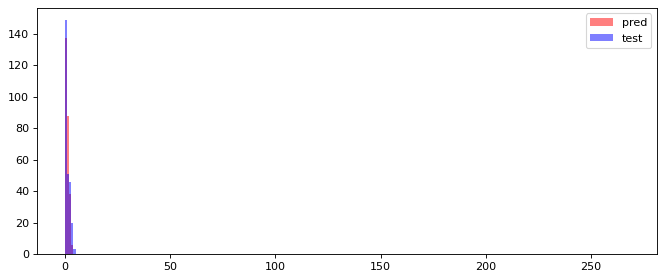

In [16]:
RFReg = RandomForest_model(train_valid, test)

## XGBoost

In [17]:
def XGB_model(train_valid, test):

    #  define model
    model = XGBRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [4, 6, 10],
                  "alpha": [0, 0.1, 0.3],
                  "eta": [0.001, 0.1, 0.3],
                  }

    # define grid search
    grid = GridSearchCV(model, parameters)

    # fit the model
    grid.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = grid.predict(get_features(test))

    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    check_prediction_value(pred, get_target(test))

    print(grid.best_params_)

    return grid.best_estimator_
    


        mae        mse     rmse      osr2
0  4.165427  72.855784  8.53556  0.591724
{'alpha': 0, 'eta': 0.1, 'max_depth': 4}


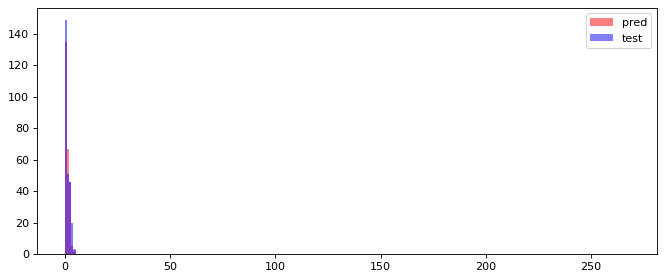

In [18]:
XGBReg = XGB_model(train_valid, test)